# DA023 Preprocess
06/13/2023

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import emd
import re

import warnings
warnings.filterwarnings('ignore')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
import sys
sys.path.append('/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/scripts/saez_python_pipeline/LFPAnalysis')

In [3]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [4]:
# Specify root directory for un-archived data and results 
base_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/'
anat_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/anat_recons/recon_labels/'
neural_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/'
behav_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/behavior_analysis/behavior_preprocessed/'

subj_id = 'DA023'
subj_format = ['edf']
subj_site = ['UCD']


### Import Data

In [5]:
edf_files = glob(f'{neural_dir}/DA023/raw/*.edf')

mne_data = mne.io.read_raw_edf(edf_files[0], preload=True)


In [6]:
mne_data

<RawEDF | DA023_SWB.edf, 174 x 983040 (1920.0 s), ~1.27 GB, data loaded>

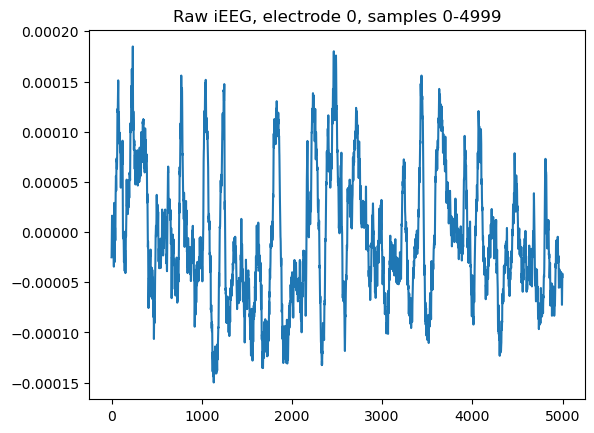

In [7]:
# Sanity check one channel data
plt.plot(mne_data._data[0,:4999])
plt.title("Raw iEEG, electrode 0, samples 0-4999")
plt.show()

In [8]:
#check raw edf names of channels
mne_data.ch_names

['LAM1',
 'LAM2',
 'LAM3',
 'LAM4',
 'LAM5',
 'LAM6',
 'LAM7',
 'LAM8',
 'LAM9',
 'LAM10',
 'LAM11',
 'LAM12',
 'LAM13',
 'LAM14',
 'LAM15',
 'LAM16',
 'LAH1',
 'LAH2',
 'LAH3',
 'LAH4',
 'LAH5',
 'LAH6',
 'LAH7',
 'LAH8',
 'LAH9',
 'LAH10',
 'LAH11',
 'LAH12',
 'LAH13',
 'LAH14',
 'LAH15',
 'LAH16',
 'LPMTG1',
 'LPMTG2',
 'LPMTG3',
 'LPMTG4',
 'LPMTG5',
 'LPMTG6',
 'LPMTG7',
 'LPMTG8',
 'LPMTG9',
 'LPMTG10',
 'LASTG1',
 'LASTG2',
 'LASTG3',
 'LASTG4',
 'LASTG5',
 'LASTG6',
 'LASTG7',
 'LASTG8',
 'LASTG9',
 'LASTG10',
 'LMSTG1',
 'LMSTG2',
 'LMSTG3',
 'LMSTG4',
 'LMSTG5',
 'LMSTG6',
 'LMSTG7',
 'LMSTG8',
 'LMSTG9',
 'LMSTG10',
 'LPSTG1',
 'LPSTG2',
 'LPSTG3',
 'LPSTG4',
 'LPSTG5',
 'LPSTG6',
 'LPSTG7',
 'LPSTG8',
 'LPSTG9',
 'LPSTG10',
 'LSMG1',
 'LSMG2',
 'LSMG3',
 'LSMG4',
 'LSMG5',
 'LSMG6',
 'LSMG7',
 'LSMG8',
 'LSMG9',
 'LSMG10',
 'LANG1',
 'LANG2',
 'LANG3',
 'LANG4',
 'LANG5',
 'LANG6',
 'LANG7',
 'LANG8',
 'LANG9',
 'LANG10',
 'LPB1',
 'LPB2',
 'LPB3',
 'LPB4',
 'LPB5',
 'LPB6'

### Examine photodiode

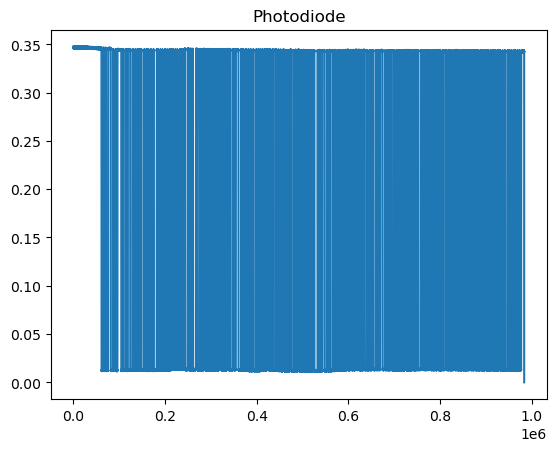

In [9]:
# Sanity check the photodiode
trig_ix = mne_data.ch_names.index('PHOTODIODE')
plt.plot(mne_data._data[trig_ix])
plt.title("Photodiode")
plt.show()

In [12]:
new_mne_names = [ch.lower() for ch in mne_data.ch_names]

In [14]:
new_name_dict = {x:y for (x,y) in zip(mne_data.ch_names, new_mne_names)}


In [16]:
new_name_dict

{'LAM1': 'lam1',
 'LAM2': 'lam2',
 'LAM3': 'lam3',
 'LAM4': 'lam4',
 'LAM5': 'lam5',
 'LAM6': 'lam6',
 'LAM7': 'lam7',
 'LAM8': 'lam8',
 'LAM9': 'lam9',
 'LAM10': 'lam10',
 'LAM11': 'lam11',
 'LAM12': 'lam12',
 'LAM13': 'lam13',
 'LAM14': 'lam14',
 'LAM15': 'lam15',
 'LAM16': 'lam16',
 'LAH1': 'lah1',
 'LAH2': 'lah2',
 'LAH3': 'lah3',
 'LAH4': 'lah4',
 'LAH5': 'lah5',
 'LAH6': 'lah6',
 'LAH7': 'lah7',
 'LAH8': 'lah8',
 'LAH9': 'lah9',
 'LAH10': 'lah10',
 'LAH11': 'lah11',
 'LAH12': 'lah12',
 'LAH13': 'lah13',
 'LAH14': 'lah14',
 'LAH15': 'lah15',
 'LAH16': 'lah16',
 'LPMTG1': 'lpmtg1',
 'LPMTG2': 'lpmtg2',
 'LPMTG3': 'lpmtg3',
 'LPMTG4': 'lpmtg4',
 'LPMTG5': 'lpmtg5',
 'LPMTG6': 'lpmtg6',
 'LPMTG7': 'lpmtg7',
 'LPMTG8': 'lpmtg8',
 'LPMTG9': 'lpmtg9',
 'LPMTG10': 'lpmtg10',
 'LASTG1': 'lastg1',
 'LASTG2': 'lastg2',
 'LASTG3': 'lastg3',
 'LASTG4': 'lastg4',
 'LASTG5': 'lastg5',
 'LASTG6': 'lastg6',
 'LASTG7': 'lastg7',
 'LASTG8': 'lastg8',
 'LASTG9': 'lastg9',
 'LASTG10': 'lastg10',
 'LM

In [17]:
#rename mne data channels to remove unnecessary labels
mne_data.rename_channels(new_name_dict)

<RawEDF | DA023_SWB.edf, 174 x 983040 (1920.0 s), ~1.27 GB, data loaded>

### Import Anat Recon Info - check all elecs are present in data + recon sheet


In [19]:
# Load the electrode localization data
da23_anat_file = glob(f'{anat_dir}/DA023_labels.csv')[0]
elec_locs = pd.read_csv(da23_anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

elec_locs

label BN246label          x          y          z      mni_x      mni_y  \
0     LAC1     A32p_L  -2.948270  35.165349  28.967987  -3.244003  29.783249   
1    LAC10     A8dl_L -17.340510  32.767711  56.937081 -18.622061  32.069451   
2    LAC11     A8dl_L -19.339433  32.368105  60.133549 -20.763493  32.332690   
3    LAC12     A8dl_L -20.938571  31.968499  62.930459 -22.441373  32.456241   
4    LAC13    Unknown -22.537708  31.968499  65.727368 -24.123625  33.000428   
..     ...        ...        ...        ...        ...        ...        ...   
145  LSMG5     A40c_L -53.720895 -36.763783  29.367546 -54.075538 -48.517991   
146  LSMG6     A40c_L -57.318955 -36.364177  30.166663 -57.724920 -47.936912   
147  LSMG7     A40c_L -60.517231 -36.364177  30.965780 -60.975772 -47.795985   
148  LSMG8     A40c_L -63.715506 -35.964570  31.764897 -64.342587 -47.285110   
149  LSMG9    Unknown -68.113135 -35.964570  32.564014 -69.044117 -47.225548   

         mni_z       gm                                 NMM            Anat  \
0    18.898609     Gray  Left ACgG anterior cingulate gyrus         Area 33   
1    49.930015     Gray     Left SFG superior frontal gyrus         Unknown   
2    53.556836     Gray     Left SFG superior frontal gyrus         Unknown   
3    56.694248     Gray     Left SFG superior frontal gyrus         Unknown   
4    59.764154  Unknown                             Unknown         Unknown   
..         ...      ...                                 ...             ...   
145  33.446039     Gray        Left SMG supramarginal gyrus  Area PFm (IPL)   
146  34.325547     Gray        Left SMG supramarginal gyrus  Area PFm (IPL)   
147  35.269393     Gray        Left SMG supramarginal gyrus  Area PFm (IPL)   
148  36.142847  Unknown        Left SMG supramarginal gyrus  Area PFm (IPL)   
149  37.149103  Unknown                             Unknown         Unknown   

                    AnatMacro    BN246                            YBA_1  \
0                       L ACC     L CG           Left cingulate gyrus G   
1    L Superior Frontal Gyrus    L SFG                          Unknown   
2    L Superior Frontal Gyrus    L SFG  Left superior frontal gyrus 4 D   
3    L Superior Frontal Gyrus    L SFG  Left superior frontal gyrus 4 D   
4                     Unknown  Unknown  Left superior frontal gyrus 4 D   
..                        ...      ...                              ...   
145     L SupraMarginal Gyrus    L IPL     Left supramarginal gyrus 3 B   
146     L SupraMarginal Gyrus    L IPL     Left supramarginal gyrus 3 B   
147     L SupraMarginal Gyrus    L IPL     Left supramarginal gyrus 3 B   
148                   Unknown    L IPL     Left supramarginal gyrus 3 B   
149                   Unknown  Unknown                          Unknown   

                   ManualExamination  
0                                NaN  
1    Left superior frontal gyrus 4 D  
2                                NaN  
3                                OOB  
4                                OOB  
..                               ...  
145                              NaN  
146                              NaN  
147                              NaN  
148                              OOB  
149                              OOB  

[150 rows x 15 columns]

In [22]:
anat_names = list(elec_locs.label.str.lower())
sum([ch not in mne_data.ch_names for ch in anat_names]) #if there are no missing channels, sum = 0. if sum >0, find the missing elecs
print([ch for ch in mne_data.ch_names if ch not in anat_names ]) #print extra channels in mne_data.ch_names and make sure none of them are neural channels (will be EEG etc.)

['fp1', 'f3', 'c3', 'p3', 'o1', 'f7', 't3', 't5', 't1', 'fp2', 'f4', 'c4', 'p4', 'o2', 'f8', 't4', 't6', 't2', 'fz', 'cz', 'pz', 'photodiode', 'audio', 'mic']


In [23]:
# Note, there is surface EEG data that we should separately indicate from the sEEG:
right_seeg_names = [i for i in mne_data.ch_names if i.startswith('r')]
left_seeg_names = [i for i in mne_data.ch_names if i.startswith('l')]
print(f'We have a total of', len(left_seeg_names), 'left &', len(right_seeg_names), 'right' 'sEEG electrodes')
print(f'We have a total of {len(left_seeg_names) + len(right_seeg_names)} sEEG electrodes')


We have a total of 150 left & 0 rightsEEG electrodes
We have a total of 150 sEEG electrodes


In [25]:
drop_chans = list(set(mne_data.ch_names)^set(left_seeg_names+right_seeg_names+['photodiode']))#set drop chans to all non neural and non photodiode channels
mne_data.drop_channels(drop_chans) #number of chans should = number of seegs + 1 (photodiode)

<RawEDF | DA023_SWB.edf, 151 x 983040 (1920.0 s), ~1.11 GB, data loaded>

In [26]:
# Set channel types:
sEEG_mapping_dict = {f'{x}':'seeg' for x in left_seeg_names+right_seeg_names}
trig_mapping_dict = {'photodiode':'stim'} #'stim test1-ref' 'Stim TEST1-REF' stim stands for stimulus 
mne_data.set_channel_types(sEEG_mapping_dict)
mne_data.set_channel_types(trig_mapping_dict)

<RawEDF | DA023_SWB.edf, 151 x 983040 (1920.0 s), ~1.11 GB, data loaded>

In [27]:
# make montage (convert mm to m)

montage = mne.channels.make_dig_montage(ch_pos=dict(zip(elec_locs.label, 
                                                        elec_locs[['mni_x', 'mni_y', 'mni_z']].to_numpy(dtype=float)/1000)),
                                        coord_frame='mni_tal')

mne_data.set_montage(montage, match_case=False, on_missing='warn')

<RawEDF | DA023_SWB.edf, 151 x 983040 (1920.0 s), ~1.11 GB, data loaded>

### Notch filter line noise

In [28]:
# Identify line noise
mne_data.info['line_freq'] = 60

# Notch out 60 Hz noise and harmonics 
mne_data.notch_filter(freqs=(60, 120, 180, 240))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    3.2s finished


<RawEDF | DA023_SWB.edf, 151 x 983040 (1920.0 s), ~1.11 GB, data loaded>

### Save out photodiode data
Note: this is after filtering out line noise

In [29]:
mne_data.save(f'{neural_dir}/DA023/photodiode.fif', picks='photodiode', overwrite=True)

### Detect bad channels - detect_bad_elecs function auto detects, then we validate manually 

In [30]:
#make_mne function auto-detects bad electrodes. I want to compare auto vs manual ictal detection

bads = lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict)
mne_data.info['bads'] = bads

#resampling this patient is not necessary 
# resample_sr = 500
# mne_data.resample(sfreq=resample_sr, npad='auto', n_jobs=-1)

In [32]:
bads

['lac12',
 'lac2',
 'lah1',
 'lmc12',
 'lmc13',
 'lmc14',
 'lmc15',
 'lmc16',
 'lmc9',
 'lpmtg3',
 'lpstg9']

In [33]:
ch_names = list(elec_locs.label.str.lower())
pattern = '[0-9]'
ch_names_no_num = [re.sub(pattern, '', i) for i in ch_names]
probe_names = np.unique(ch_names_no_num)

In [34]:
probe_names

array(['lac', 'lah', 'lam', 'lang', 'lastg', 'lmc', 'lmstg', 'locc',
       'lpb', 'lpmtg', 'lpstg', 'lsmg'], dtype='<U5')

In [35]:
probe_ch_counts = {} #need this to select channel number for visualization
for p in probe_names:
    c = ch_names_no_num.count(p)
    probe_ch_counts[p] = c

In [36]:
probe_ch_counts

{'lac': 16,
 'lah': 16,
 'lam': 16,
 'lang': 10,
 'lastg': 10,
 'lmc': 16,
 'lmstg': 10,
 'locc': 10,
 'lpb': 16,
 'lpmtg': 10,
 'lpstg': 10,
 'lsmg': 10}

<IPython.core.display.Javascript object>


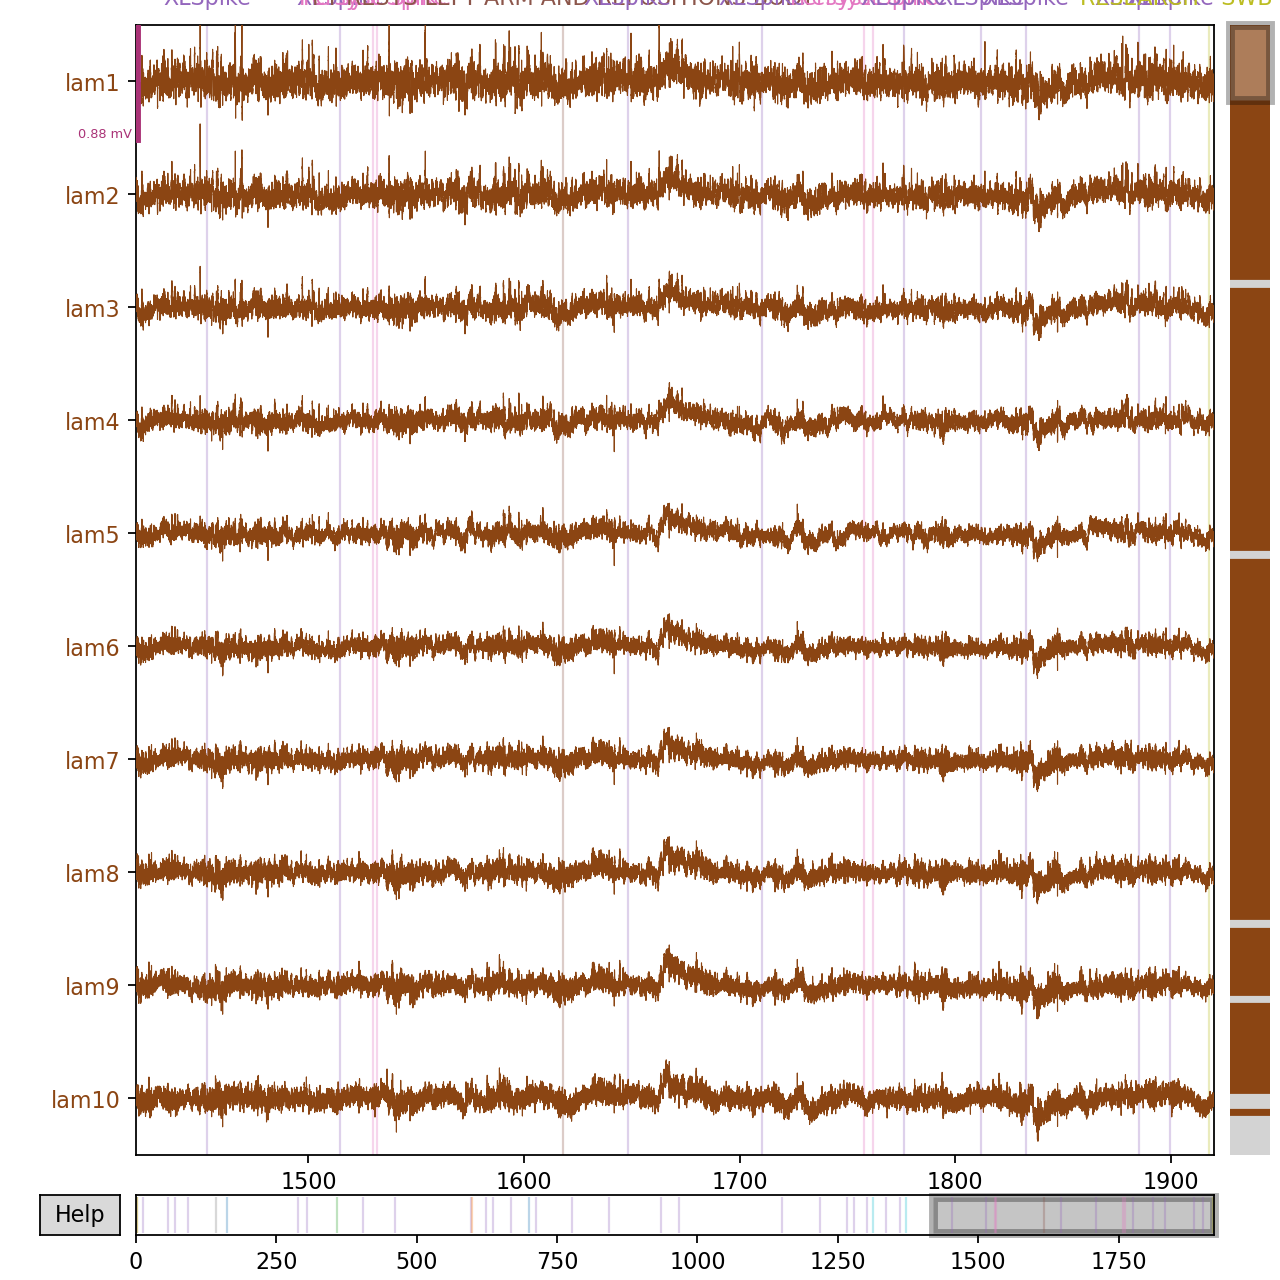

<IPython.core.display.Javascript object>


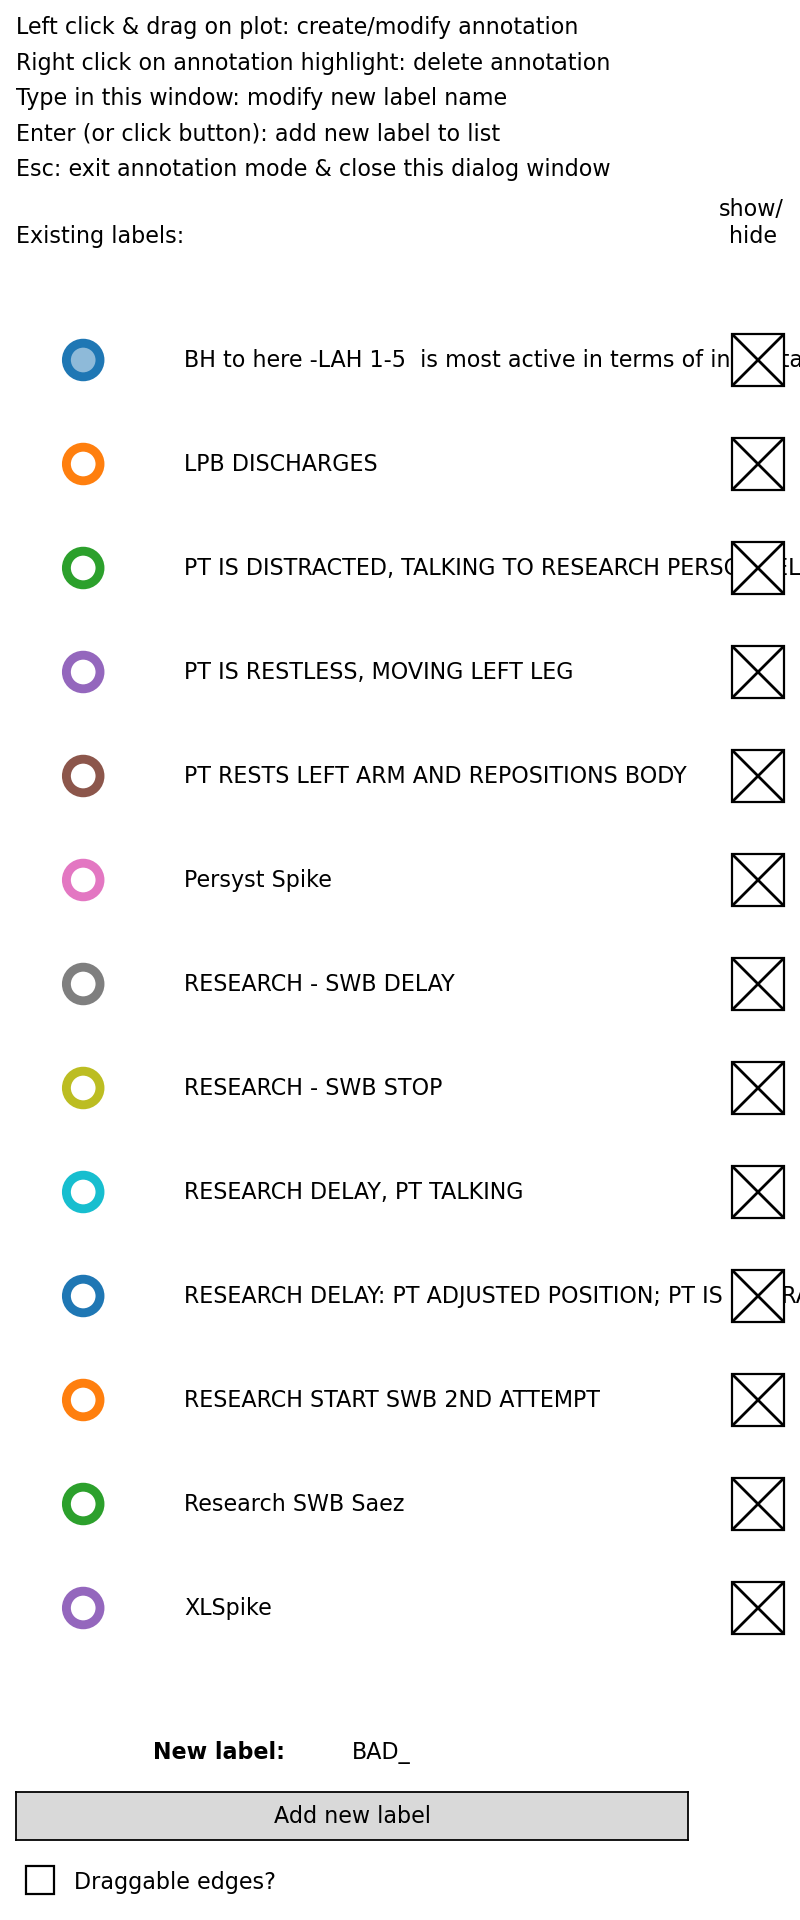

In [42]:
%matplotlib notebook
fig = mne_data.plot(start=0, duration=500, n_channels=10, scalings=mne_data._data.max()/20)
fig.fake_keypress('a')

<IPython.core.display.Javascript object>


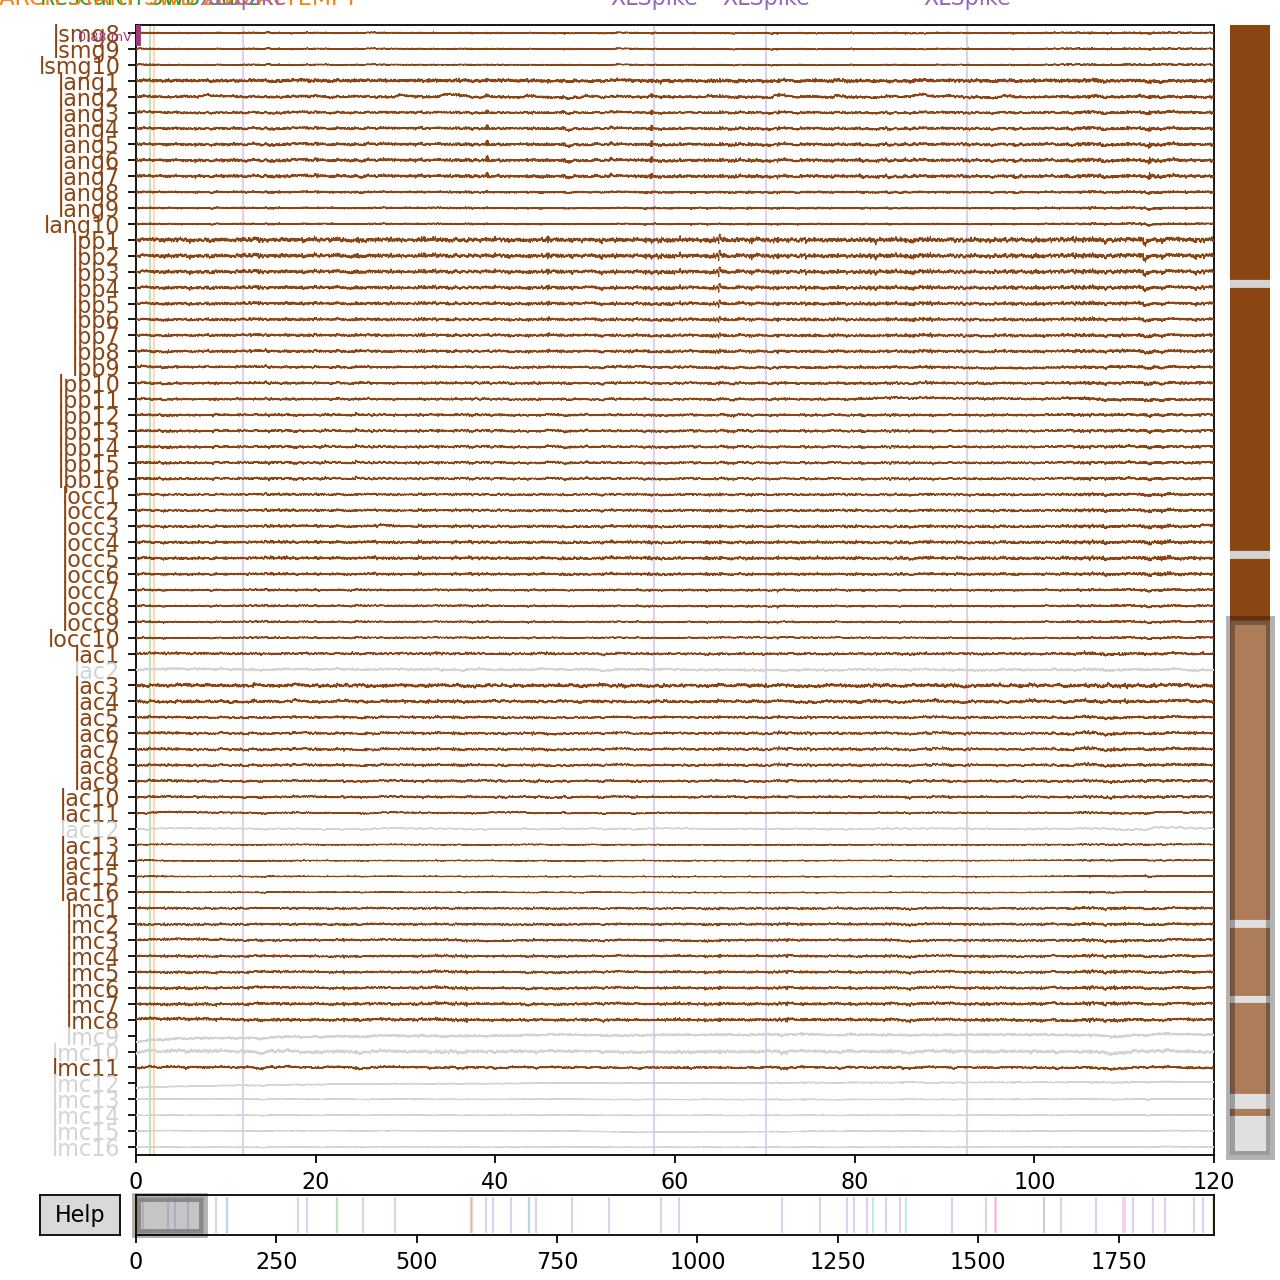

<IPython.core.display.Javascript object>


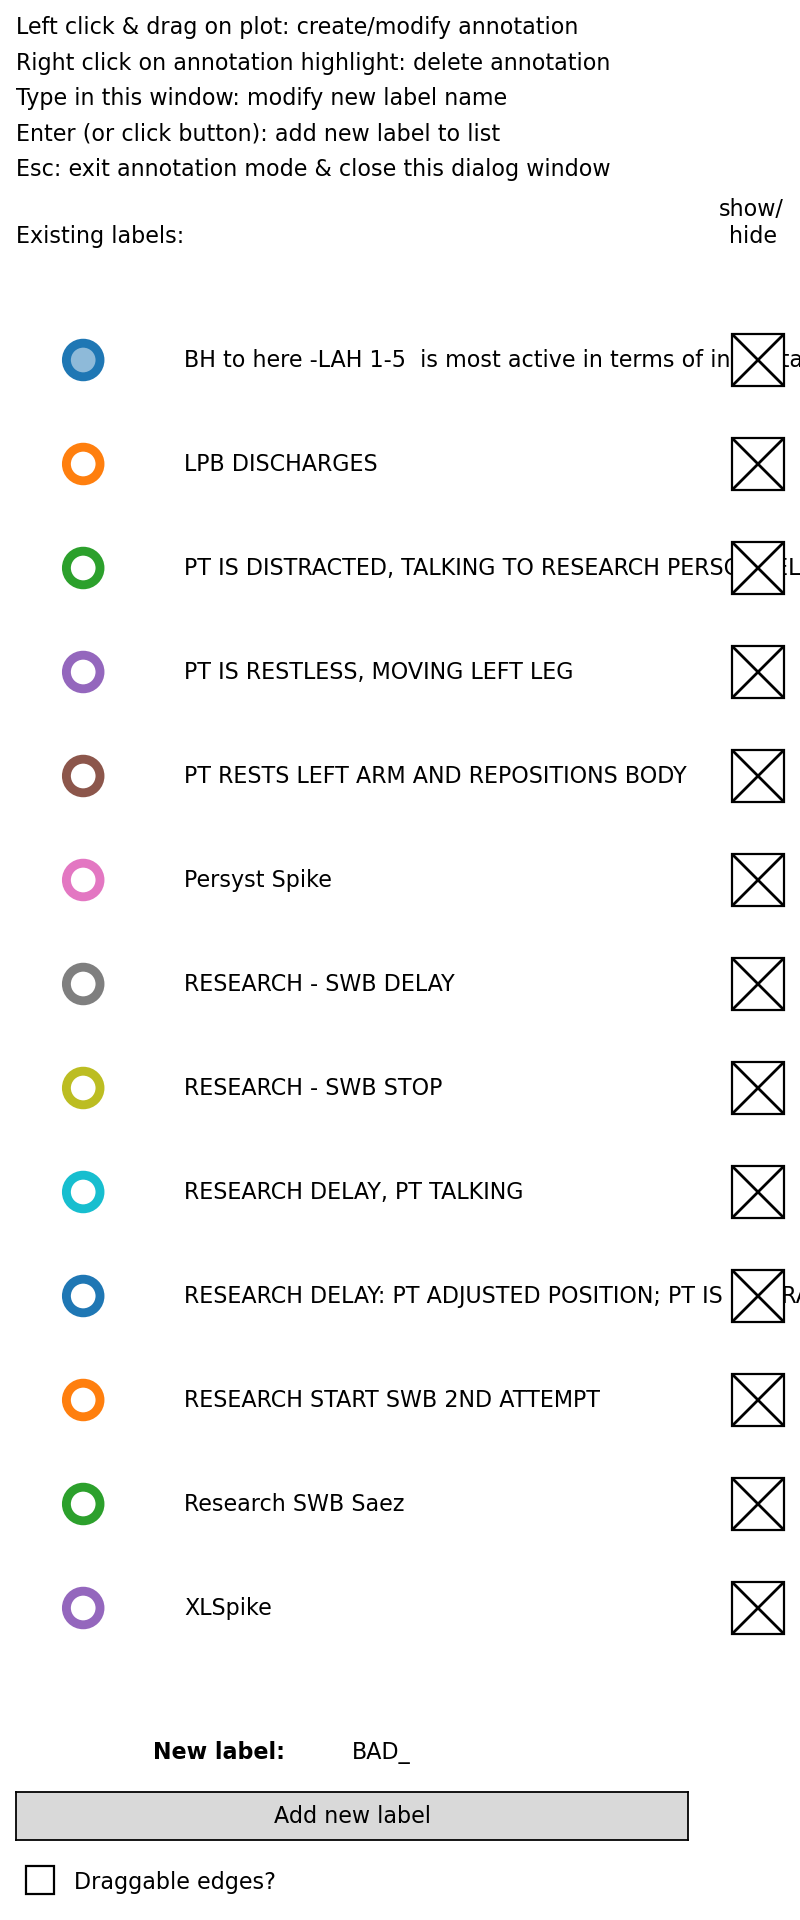

In [43]:
%matplotlib notebook
fig = mne_data.plot(start=0, duration=120, n_channels=71, scalings=mne_data._data.max()/20)
fig.fake_keypress('a')

In [ ]:
##save info in SWB_electrode_info spreadsheet!
#['lip10', 'lpo10', 'lpo2', 'lpo5', 'lpo6', 'lpo8', 'ltp9', 'ltt1', 'ltt2', 'ltt3', 'ltt4', 'ltp1', 'ltp3', 'ltp6', 'ltp2', 'ltp10', 'lpo3', 'lpo4', 'lpo7', 'lpo9', 'ltt7', 'ltp8']

In [44]:
mne_data.info['bads']

['lac12',
 'lac2',
 'lmc12',
 'lmc13',
 'lmc14',
 'lmc15',
 'lmc16',
 'lmc9',
 'lpmtg3',
 'lpstg9',
 'lmc10']

In [45]:
#set bad channel info 
da23_bad_ch = ['lac12',
 'lac2',
 'lmc12',
 'lmc13',
 'lmc14',
 'lmc15',
 'lmc16',
 'lmc9',
 'lpmtg3',
 'lpstg9',
 'lmc10']


In [46]:
#manually set bads because doing it in the plot is too buggy
mne_data.info['bads'] = da23_bad_ch

In [47]:
mne_data.info #sanity check that bads info saved

<Info | 10 non-empty values
 bads: 11 items (lac12, lac2, lmc12, lmc13, lmc14, lmc15, lmc16, lmc9, ...)
 ch_names: lam1, lam2, lam3, lam4, lam5, lam6, lam7, lam8, lam9, lam10, ...
 chs: 150 sEEG
 custom_ref_applied: False
 dig: 150 items (150 EEG)
 highpass: 0.0 Hz
 line_freq: 60.0
 lowpass: 256.0 Hz
 meas_date: 2023-03-31 14:14:25 UTC
 nchan: 150
 projs: []
 sfreq: 512.0 Hz
>

In [48]:
mne_data.info['bads'] #more sanity checking

['lac12',
 'lac2',
 'lmc12',
 'lmc13',
 'lmc14',
 'lmc15',
 'lmc16',
 'lmc9',
 'lpmtg3',
 'lpstg9',
 'lmc10']

### Rereference data to wm electrodes

In [49]:
unmatched_seeg = [] #need this to run script, also need site = 'MSSM' because davis site specificity hasn't been implemented yet 

In [50]:
anode_list, cathode_list, drop_wm_channels, oob_channels = lfp_preprocess_utils.wm_ref(mne_data=mne_data, 
                                                                                elec_path=da23_anat_file, 
                                                                                unmatched_seeg = unmatched_seeg,
                                                                                bad_channels=mne_data.info['bads'],
                                                                                      site = 'MSSM')

In [51]:
oob_channels

['lac13',
 'lac14',
 'lac15',
 'lac16',
 'lam14',
 'lam15',
 'lam16',
 'lang10',
 'lang9',
 'lastg10',
 'lastg8',
 'lastg9',
 'lmc12',
 'lmc13',
 'lmc14',
 'lmc15',
 'lmc16',
 'lmstg10',
 'lmstg9',
 'locc10',
 'locc8',
 'locc9',
 'lpb13',
 'lpb14',
 'lpb15',
 'lpb16',
 'lpmtg10',
 'lpmtg8',
 'lpmtg9',
 'lpstg10',
 'lpstg9',
 'lsmg10',
 'lsmg8',
 'lsmg9']

In [55]:
#need to distinguish between wm channels and oob channels 

#add oob channels to bad channels list
#da23_bad_ch = ['lac12','lac2','lmc12','lmc13','lmc14','lmc15','lmc16','lmc9','lpmtg3','lpstg9','lmc10']
da23_bad_ch = da23_bad_ch + oob_channels
da23_bad_ch = list(np.unique(da23_bad_ch)) #check length against spreadsheet
mne_data.info['bads'] = da23_bad_ch

In [58]:
mne_data.info['bads'] #needed to rerun plotting function to find this again?

['lac12',
 'lac13',
 'lac14',
 'lac15',
 'lac16',
 'lac2',
 'lam14',
 'lam15',
 'lam16',
 'lang10',
 'lang9',
 'lastg10',
 'lastg8',
 'lastg9',
 'lmc10',
 'lmc12',
 'lmc13',
 'lmc14',
 'lmc15',
 'lmc16',
 'lmc9',
 'lmstg10',
 'lmstg9',
 'locc10',
 'locc8',
 'locc9',
 'lpb13',
 'lpb14',
 'lpb15',
 'lpb16',
 'lpmtg10',
 'lpmtg3',
 'lpmtg8',
 'lpmtg9',
 'lpstg10',
 'lpstg9',
 'lsmg10',
 'lsmg8',
 'lsmg9']

In [59]:
mne_data_reref = mne.set_bipolar_reference(mne_data, 
                      anode=anode_list, 
                      cathode=cathode_list,
                      copy=True)

In [60]:
mne_data_reref

<RawEDF | DA023_SWB.edf, 125 x 983040 (1920.0 s), ~937.7 MB, data loaded>

### Save cleaned continuous data

In [61]:
mne_data.save(f'{neural_dir}/DA023/lfp_data.fif')

In [62]:
mne_data_reref.save(f'{neural_dir}/DA023/wm_ref_ieeg.fif')